<a href="https://colab.research.google.com/github/Jhancyamarsingh17/Automated-medical-report-generation-and-classification-/blob/main/Transformer_model_draft_SP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [89]:
import tensorflow as tf


# img = tf.keras.preprocessing.image.load_img('/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/images/images_normalized/2224_IM-0828-2001.dcm.png')


In [90]:
import pandas as pd
import numpy as np
import regex as re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [91]:
d1= pd.read_csv('/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/indiana_projections.csv')
d2= pd.read_csv('/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/indiana_reports.csv')

In [92]:
d1.head()

uid                filename projection
0    1  1_IM-0001-4001.dcm.png    Frontal
1    1  1_IM-0001-3001.dcm.png    Lateral
2    2  2_IM-0652-1001.dcm.png    Frontal
3    2  2_IM-0652-2001.dcm.png    Lateral
4    3  3_IM-1384-1001.dcm.png    Frontal

In [93]:
d2.head()

uid                                               MeSH  \
0    1                                             normal   
1    2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
2    3                                             normal   
3    4  Pulmonary Disease, Chronic Obstructive;Bullous...   
4    5  Osteophyte/thoracic vertebrae/multiple/small;T...   

                                            Problems  \
0                                             normal   
1                      Cardiomegaly;Pulmonary Artery   
2                                             normal   
3  Pulmonary Disease, Chronic Obstructive;Bullous...   
4                         Osteophyte;Thickening;Lung   

                                               image  \
0                          Xray Chest PA and Lateral   
1                Chest, 2 views, frontal and lateral   
2                          Xray Chest PA and Lateral   
3  PA and lateral views of the chest XXXX, XXXX a...   
4                          Xray Chest PA and Lateral   

                                          indication      comparison  \
0                                   Positive TB test           None.   
1                           Preop bariatric surgery.           None.   
2  rib pain after a XXXX, XXXX XXXX steps this XX...             NaN   
3                      XXXX-year-old XXXX with XXXX.  None available   
4                        Chest and nasal congestion.             NaN   

                                            findings  \
0  The cardiac silhouette and mediastinum size ar...   
1  Borderline cardiomegaly. Midline sternotomy XX...   
2                                                NaN   
3  There are diffuse bilateral interstitial and a...   
4  The cardiomediastinal silhouette and pulmonary...   

                                          impression  
0                               Normal chest x-XXXX.  
1                       No acute pulmonary findings.  
2  No displaced rib fractures, pneumothorax, or p...  
3  1. Bullous emphysema and interstitial fibrosis...  
4              No acute cardiopulmonary abnormality.

In [94]:
print(d1.shape)
print(d2.shape)

(7466, 3)
(3851, 8)


In [95]:
orig_data  = pd.merge(d1, d2, left_on="uid", right_on="uid")
print(orig_data.shape)
orig_data.head()

(7466, 10)


uid                filename projection  \
0    1  1_IM-0001-4001.dcm.png    Frontal   
1    1  1_IM-0001-3001.dcm.png    Lateral   
2    2  2_IM-0652-1001.dcm.png    Frontal   
3    2  2_IM-0652-2001.dcm.png    Lateral   
4    3  3_IM-1384-1001.dcm.png    Frontal   

                                                MeSH  \
0                                             normal   
1                                             normal   
2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
3  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
4                                             normal   

                        Problems                                image  \
0                         normal            Xray Chest PA and Lateral   
1                         normal            Xray Chest PA and Lateral   
2  Cardiomegaly;Pulmonary Artery  Chest, 2 views, frontal and lateral   
3  Cardiomegaly;Pulmonary Artery  Chest, 2 views, frontal and lateral   
4                         normal            Xray Chest PA and Lateral   

                                          indication comparison  \
0                                   Positive TB test      None.   
1                                   Positive TB test      None.   
2                           Preop bariatric surgery.      None.   
3                           Preop bariatric surgery.      None.   
4  rib pain after a XXXX, XXXX XXXX steps this XX...        NaN   

                                            findings  \
0  The cardiac silhouette and mediastinum size ar...   
1  The cardiac silhouette and mediastinum size ar...   
2  Borderline cardiomegaly. Midline sternotomy XX...   
3  Borderline cardiomegaly. Midline sternotomy XX...   
4                                                NaN   

                                          impression  
0                               Normal chest x-XXXX.  
1                               Normal chest x-XXXX.  
2                       No acute pulmonary findings.  
3                       No acute pulmonary findings.  
4  No displaced rib fractures, pneumothorax, or p...

In [96]:
# orig_data= pd.read_csv('/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/TransChex_openi/df_final.csv')
# orig_data.drop(columns=['Unnamed: 0'], inplace=True)

In [97]:
orig_data.columns

Index(['uid', 'filename', 'projection', 'MeSH', 'Problems', 'image',
       'indication', 'comparison', 'findings', 'impression'],
      dtype='object')

In [98]:
orig_data.head()


uid                filename projection  \
0    1  1_IM-0001-4001.dcm.png    Frontal   
1    1  1_IM-0001-3001.dcm.png    Lateral   
2    2  2_IM-0652-1001.dcm.png    Frontal   
3    2  2_IM-0652-2001.dcm.png    Lateral   
4    3  3_IM-1384-1001.dcm.png    Frontal   

                                                MeSH  \
0                                             normal   
1                                             normal   
2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
3  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
4                                             normal   

                        Problems                                image  \
0                         normal            Xray Chest PA and Lateral   
1                         normal            Xray Chest PA and Lateral   
2  Cardiomegaly;Pulmonary Artery  Chest, 2 views, frontal and lateral   
3  Cardiomegaly;Pulmonary Artery  Chest, 2 views, frontal and lateral   
4                         normal            Xray Chest PA and Lateral   

                                          indication comparison  \
0                                   Positive TB test      None.   
1                                   Positive TB test      None.   
2                           Preop bariatric surgery.      None.   
3                           Preop bariatric surgery.      None.   
4  rib pain after a XXXX, XXXX XXXX steps this XX...        NaN   

                                            findings  \
0  The cardiac silhouette and mediastinum size ar...   
1  The cardiac silhouette and mediastinum size ar...   
2  Borderline cardiomegaly. Midline sternotomy XX...   
3  Borderline cardiomegaly. Midline sternotomy XX...   
4                                                NaN   

                                          impression  
0                               Normal chest x-XXXX.  
1                               Normal chest x-XXXX.  
2                       No acute pulmonary findings.  
3                       No acute pulmonary findings.  
4  No displaced rib fractures, pneumothorax, or p...

In [99]:
# orig_data[['id', 'report', 'INDICATION', 'FINDINGS',
#        'IMPRESSION', 'images', 'indication', 'finding', 'impression',
#        'images_id1', 'images_id2', 'images_id3', 'images_id4', 'images_id5',  'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
#        'Enlarged-Cardiomediastinum', 'Fracture', 'Lung-Lesion', 'Lung-Opacity',
#        'No-Finding', 'Pleural-Effusion', 'Pleural_Other', 'Pneumonia',
#        'Pneumothorax', 'Support-Devices']].head()

In [100]:
# orig_data['report'][0]

In [101]:
# orig_data = orig_data[['id', 'report', 'images', 'indication', 'finding', 'impression',
#        'images_id1', 'images_id2', 'images_id3', 'images_id4', 'images_id5',  'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
#        'Enlarged-Cardiomediastinum', 'Fracture', 'Lung-Lesion', 'Lung-Opacity',
#        'No-Finding', 'Pleural-Effusion', 'Pleural_Other', 'Pneumonia',
#        'Pneumothorax', 'Support-Devices']]

In [102]:
# orig_data.head()

In [103]:
# orig_data.drop(columns= ['images_id3', 'images_id4', 'images_id5'], inplace=True)

In [104]:
#Check for Null values in Text columns
NaN = (orig_data.isnull().sum()*100/ len(orig_data)).round(1)

# print("Total Nan Values in Indication columns -",NaN[3])
# print("Total Nan Values in findings columns   -",NaN[4])
# print("Total Nan Values in Impression columns -",NaN[5])
NaN

uid            0.0
filename       0.0
projection     0.0
MeSH           0.0
Problems       0.0
image          0.0
indication     2.1
comparison    15.5
findings      13.4
impression     0.7
dtype: float64

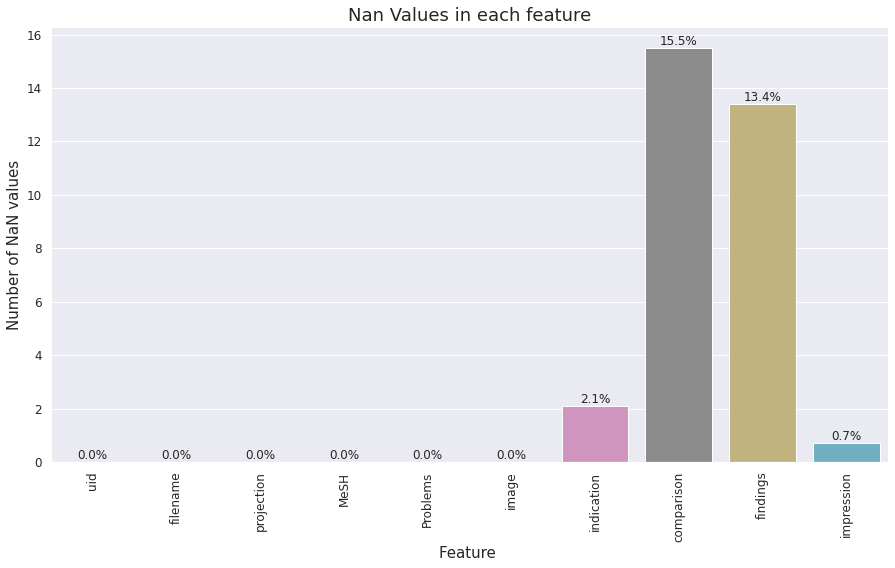

In [105]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(orig_data.columns, NaN.values)
plt.title("Nan Values in each feature", fontsize=18)
plt.ylabel('Number of NaN values', fontsize=15)
plt.xlabel('Feature ', fontsize=15)
plt.xticks(rotation = 90, fontsize=12) 
plt.yticks( fontsize=12) 

#adding the text labels
rects = ax.patches
labels =NaN.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height , str(label) + '%' , ha='center', va='bottom', fontsize=12)
plt.show()

In [106]:
  #Handling NULL values

In [107]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
def decontraction(doc):
    docs = re.sub(r"won't", "will not", doc)
    docs = re.sub(r"can\'t", "can not", docs)
    docs = re.sub(r"n\'t", " not", docs)
    docs = re.sub(r"\'re", " are", docs)
    docs = re.sub(r"\'s", " is", docs)
    docs = re.sub(r"\'d", " would", docs)
    docs = re.sub(r"\'ll", " will", docs)
    docs = re.sub(r"\'t", " not", docs)
    docs = re.sub(r"\'ve", " have", docs)
    docs = re.sub(r"\'m", " am",docs)
    docs = re.sub(r"n\'t", " not", docs)
    docs = re.sub(r"\'re", " are", docs)
    docs = re.sub(r"\'s", " is", docs)
    docs = re.sub(r"\'d", " would", docs)
    docs = re.sub(r"\'ll", " will", docs)
    docs = re.sub(r"\'t", " not", docs)
    docs = re.sub(r"\'ve", " have",docs)
    docs = re.sub(r"\'m", " am", docs)
    docs = re.sub(r"\*+", "abuse", docs)
    return docs

def remove_stopwords(data):
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')# removing the "not" from the stopwords
  all_stopwords.remove('no')
  text_tokens = word_tokenize(data) # tokenizing the sentence into word
  tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
  return " ".join(tokens_without_sw)

def text_preprocess(data):
  clean_text=[]
  text=str(data)
  # for i in (data.values):
  #   text = BeautifulSoup(i, 'lxml').get_text()
  text=text.lower()# making the text in lower case
  text=re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]","",text)# removing the special character in text
  text=re.sub(r"xxxx","",text)# Removing the irrelavent XXXX words
  text=re.sub(r'xxx',"",text)
  text=re.sub(r'xx',"",text)
  text=re.sub(r'[0-9]',"",text)# Removing the number in text
  text = re.sub(r"yearold", "", text)
  text= re.sub('\s+',' ',text)
  text=re.sub("'",'',text)# Removing apoustahe
  text=re.sub(r'\.\.+', '.',text)# Removing multiple full stop
  text=re.sub(r'  ',"",text)
  text=decontraction(text)
  text=remove_stopwords(text)
  
  return text
#  
orig_data["indication"]=orig_data["indication"].apply(lambda x:text_preprocess(x))
orig_data["finding"]=orig_data["findings"].apply(lambda x:text_preprocess(x))
orig_data["impression"]=orig_data["impression"].apply(lambda x:text_preprocess(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [108]:
orig_data

uid                   filename projection  \
0        1     1_IM-0001-4001.dcm.png    Frontal   
1        1     1_IM-0001-3001.dcm.png    Lateral   
2        2     2_IM-0652-1001.dcm.png    Frontal   
3        2     2_IM-0652-2001.dcm.png    Lateral   
4        3     3_IM-1384-1001.dcm.png    Frontal   
...    ...                        ...        ...   
7461  3997  3997_IM-2048-1002.dcm.png    Lateral   
7462  3998  3998_IM-2048-1001.dcm.png    Frontal   
7463  3998  3998_IM-2048-1002.dcm.png    Lateral   
7464  3999  3999_IM-2049-1001.dcm.png    Frontal   
7465  3999  3999_IM-2049-2001.dcm.png    Lateral   

                                                   MeSH  \
0                                                normal   
1                                                normal   
2     Cardiomegaly/borderline;Pulmonary Artery/enlarged   
3     Cardiomegaly/borderline;Pulmonary Artery/enlarged   
4                                                normal   
...                                                 ...   
7461  Opacity/lung/upper lobe/right/round/small;Gran...   
7462                                             normal   
7463                                             normal   
7464                                             normal   
7465                                             normal   

                           Problems  \
0                            normal   
1                            normal   
2     Cardiomegaly;Pulmonary Artery   
3     Cardiomegaly;Pulmonary Artery   
4                            normal   
...                             ...   
7461              Opacity;Granuloma   
7462                         normal   
7463                         normal   
7464                         normal   
7465                         normal   

                                                  image  \
0                             Xray Chest PA and Lateral   
1                             Xray Chest PA and Lateral   
2                   Chest, 2 views, frontal and lateral   
3                   Chest, 2 views, frontal and lateral   
4                             Xray Chest PA and Lateral   
...                                                 ...   
7461                PA and lateral views of the chest.    
7462   PA and lateral chest XXXX, XXXX XXXX comparis...   
7463   PA and lateral chest XXXX, XXXX XXXX comparis...   
7464              CHEST PA and LATERAL: on XXXX, XXXX.    
7465              CHEST PA and LATERAL: on XXXX, XXXX.    

                                             indication  \
0                                      positive tb test   
1                                      positive tb test   
2                               preop bariatric surgery   
3                               preop bariatric surgery   
4     rib pain steps pain r back r elbow r rib no pr...   
...                                                 ...   
7461                                  male positive ppd   
7462                          tuberculosis positive ppd   
7463                          tuberculosis positive ppd   
7464                    female patient shortness breath   
7465                    female patient shortness breath   

                     comparison  \
0                         None.   
1                         None.   
2                         None.   
3                         None.   
4                           NaN   
...                         ...   
7461            None available.   
7462                        NaN   
7463                        NaN   
7464  Chest x-XXXX, XXXX, XXXX.   
7465  Chest x-XXXX, XXXX, XXXX.   

                                               findings  \
0     The cardiac silhouette and mediastinum size ar...   
1     The cardiac silhouette and mediastinum size ar...   
2     Borderline cardiomegaly. Midline sternotomy XX...   
3     Borderline cardiomegaly. Midline sternotomy XX...   
4                                                   NaN   
...        

In [109]:
orig_data.shape

(7466, 11)

In [110]:
# categories = ['Atelectasis',
#  'Cardiomegaly',
#  'Consolidation',
#  'Edema',
#  'Enlarged-Cardiomediastinum',
#  'Fracture',
#  'Lung-Lesion',
#  'Lung-Opacity',
#  'No-Finding',
#  'Pleural-Effusion',
#  'Pleural_Other',
#  'Pneumonia',
#  'Pneumothorax',
#  'Support-Devices']

In [111]:
# class_labels_count = pd.DataFrame(orig_data.iloc[:,10:].sum().values, categories, columns=[ 'Count'])
# class_labels_count.sort_values(by=['Count'], ascending=False)


In [112]:
# len(orig_data.loc[(orig_data['No-Finding'] == 1) & (orig_data['Lung-Opacity'] ==0)
#               & (orig_data['Enlarged-Cardiomediastinum'] ==0)& (orig_data['Cardiomegaly'] ==0)
#               & (orig_data['Atelectasis'] ==0)& (orig_data['Support-Devices'] ==0)
#               & (orig_data['Pleural-Effusion'] ==0)& (orig_data['Lung-Lesion'] ==0)
#               & (orig_data['Fracture'] ==0)& (orig_data['Consolidation'] ==0)
#               & (orig_data['Pleural_Other'] ==0)& (orig_data['Edema'] ==0)
#               & (orig_data['Pneumonia'] ==0)& (orig_data['Pneumothorax'] ==0)])

In [113]:
# class_labels_count = pd.DataFrame(orig_data.iloc[:,8:].sum().values, categories, columns=[ 'Count'])
# class_labels_count.sort_values(by=['Count'], ascending=False)

# sns.set(font_scale = 2)
# plt.figure(figsize=(15,8))
# ax= sns.barplot(categories, class_labels_count['Count'])
# plt.title("Records w.r.t. each class", fontsize=18)
# plt.ylabel('Number of records', fontsize=15)
# plt.xlabel('Class Label ', fontsize=15)
# plt.xticks(rotation = 90, fontsize=12) 
# plt.yticks( fontsize=12) 

# #adding the text labels
# rects = ax.patches
# labels = orig_data.iloc[:,10:].sum().values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)
# plt.show()

In [114]:

# df_sum = pd.DataFrame(orig_data[categories].sum(axis=1, numeric_only=True), columns=[ 'Count'])
# df_sum.sort_values(by=['Count'], ascending=False)


In [115]:
# rowSums = orig_data.iloc[:,8:].sum(axis=1)
# multiLabel_counts = rowSums.value_counts()
# multiLabel_counts = multiLabel_counts.iloc[1:]
# sns.set(font_scale = 1)
# plt.figure(figsize=(12,8))
# ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
# plt.title("Records with multiple class ", fontsize=18)
# plt.ylabel('Number of Records', fontsize=12)
# plt.xlabel('Number of class', fontsize=12)
# #adding the text labels
# rects = ax.patches
# labels = multiLabel_counts.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
# plt.show()

In [116]:
# orig_data['image_count'] = orig_data['image'].astype(str).str.split(',').apply(len)
# #Adding word count feature for indication, findings and impression
# dataframe['indication_count'] = dataframe['indication'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
# dataframe['findings_count'] = dataframe['findings'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
# dataframe['impression_count'] = dataframe['impression'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
# dataframe.head()


0                                        positive tb test
1                                        positive tb test
2                                 preop bariatric surgery
3                                 preop bariatric surgery
4       rib pain steps pain r back r elbow r rib no pr...
                              ...                        
7461                                    male positive ppd
7462                            tuberculosis positive ppd
7463                            tuberculosis positive ppd
7464                      female patient shortness breath
7465                      female patient shortness breath
Length: 7466, dtype: object
no. of unique indication report in the dataset:1943
No. of indication report repeated more than one times:1742


<BarContainer object of 1 artists>

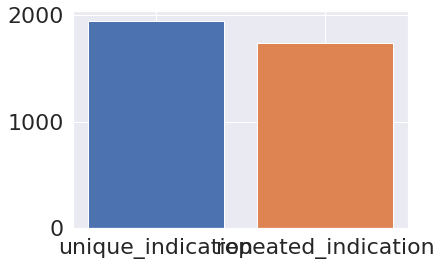

In [117]:
import matplotlib.pyplot as plt
indication_reports=pd.Series(orig_data["indication"].tolist())
print(indication_reports)
len_indication=len(indication_reports)
unique_indication_report=len(np.unique(indication_reports))
print("no. of unique indication report in the dataset:{}".format(unique_indication_report))
repeated_indication_report=np.sum(indication_reports.value_counts()>1)
print("No. of indication report repeated more than one times:{}".format(repeated_indication_report))
plt.bar(["unique_indication"], unique_indication_report)
plt.bar(["repeated_indication"], repeated_indication_report )




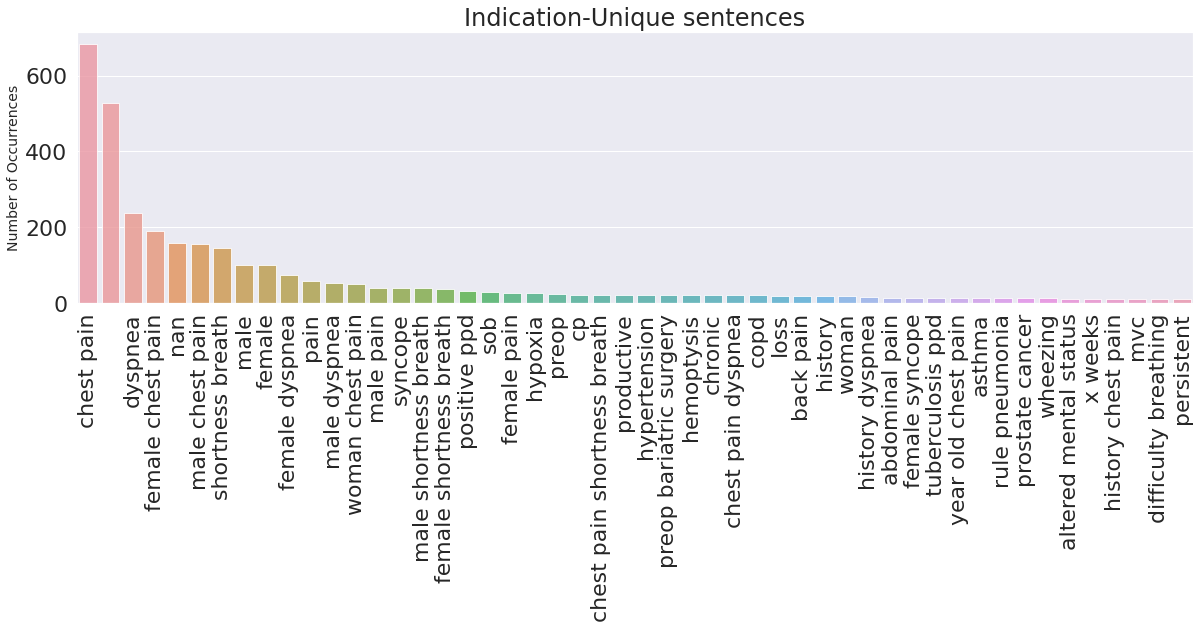

In [118]:
import seaborn as sns

#Plotting top 50 frequent sentences of Indication feature
sentences = orig_data['indication'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(sentences.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xticks(rotation=90)
plt.title("Indication-Unique sentences")
plt.show()

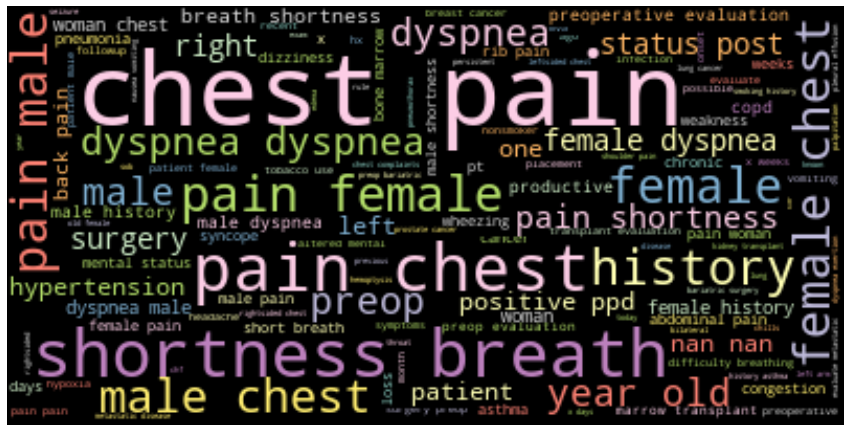

In [119]:
from wordcloud import WordCloud 

wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(orig_data['indication'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

0       The cardiac silhouette and mediastinum size ar...
1       The cardiac silhouette and mediastinum size ar...
2       Borderline cardiomegaly. Midline sternotomy XX...
3       Borderline cardiomegaly. Midline sternotomy XX...
4                                                     NaN
                              ...                        
7461    Heart size within normal limits. Small, nodula...
7462                                                  NaN
7463                                                  NaN
7464                                                  NaN
7465                                                  NaN
Length: 7466, dtype: object
no. of unique findings report in the dataset:7466
No. of findings report repeated more than one times:2266


<BarContainer object of 1 artists>

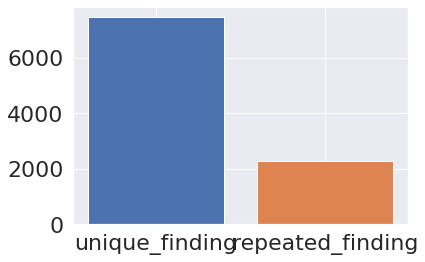

In [120]:
findings_reports=pd.Series(orig_data["findings"].tolist())
print(findings_reports)
len_findings=len(findings_reports)
unique_findings_report=len((findings_reports))
print("no. of unique findings report in the dataset:{}".format(unique_findings_report))
repeated_findings_report=np.sum(findings_reports.value_counts()>1)
print("No. of findings report repeated more than one times:{}".format(repeated_findings_report))
plt.bar(["unique_finding"], unique_findings_report)
plt.bar(["repeated_finding"], repeated_findings_report )

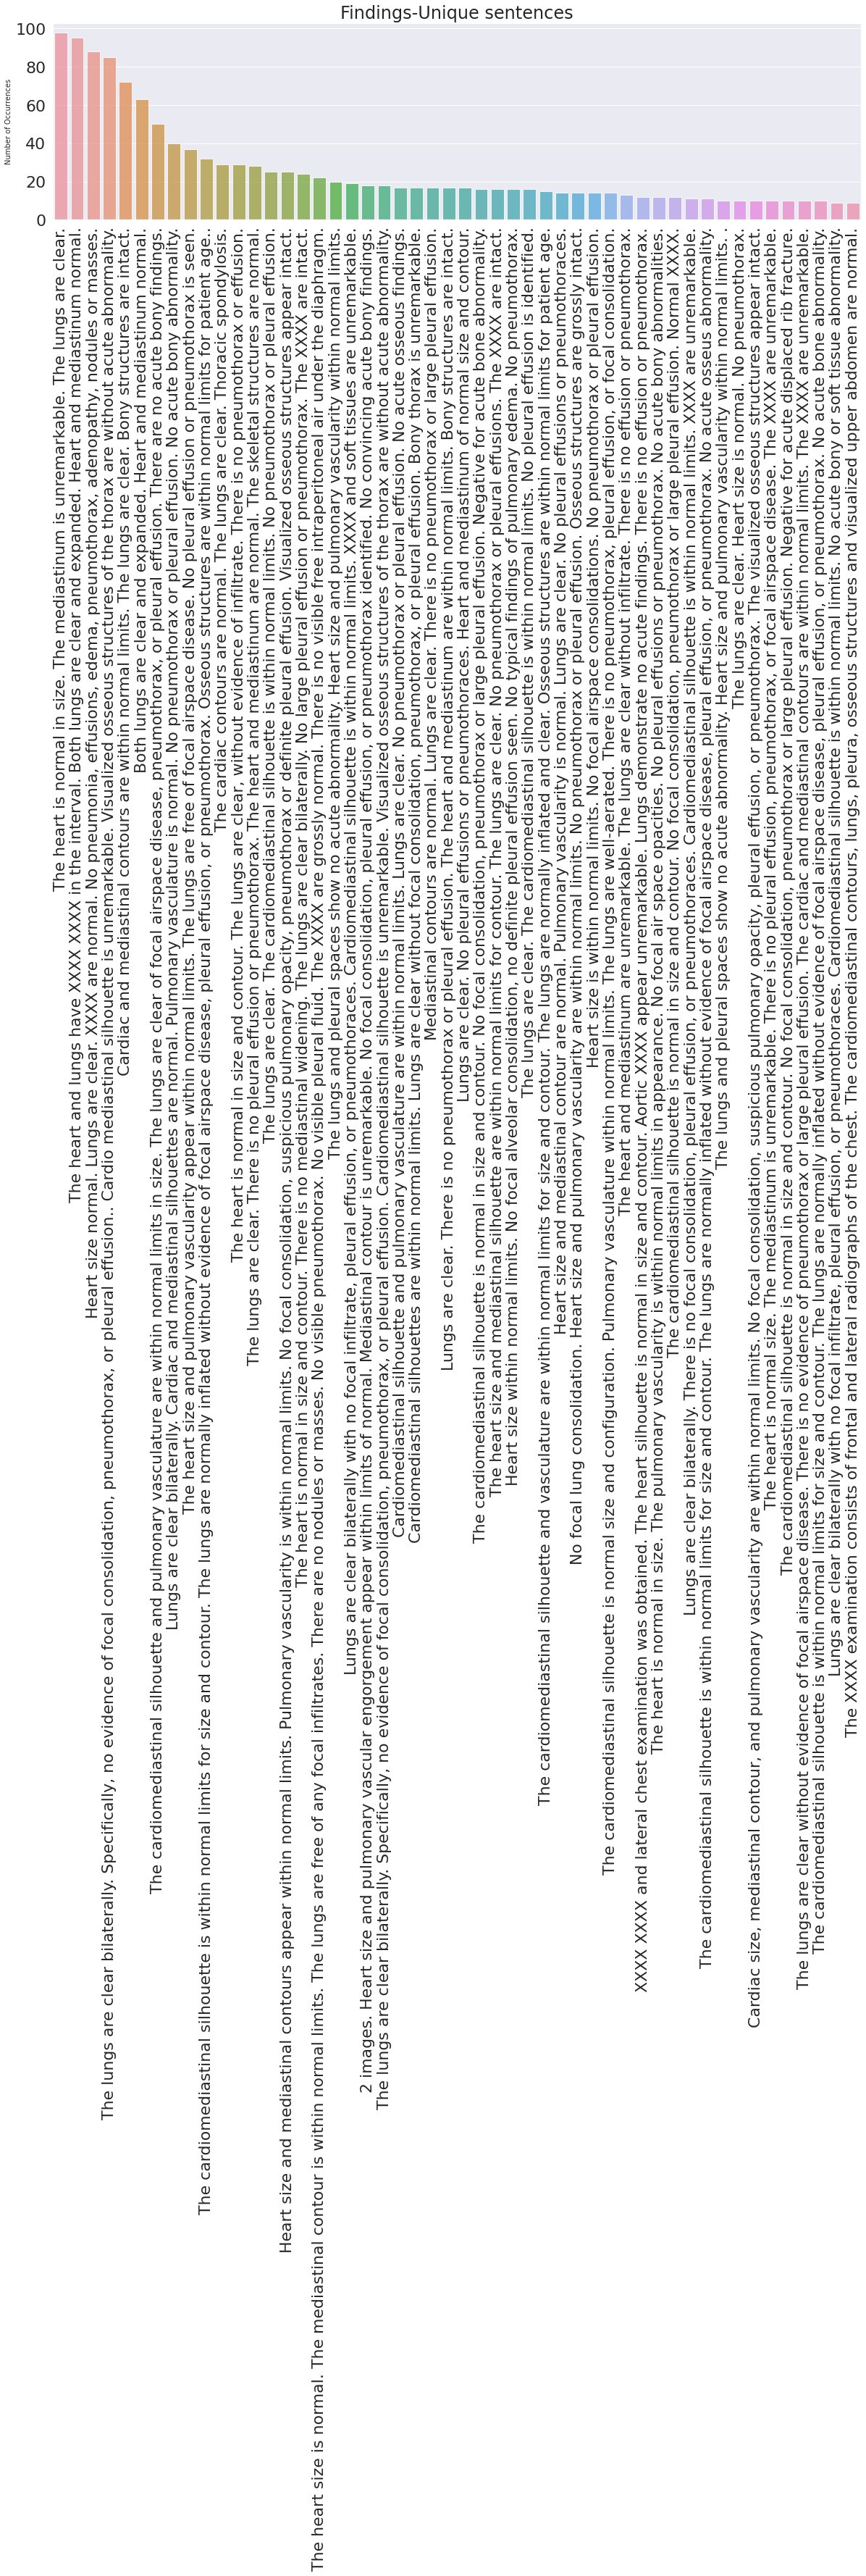

In [123]:
#Plotting top 50 frequent sentences of Findings feature
sentences = orig_data['findings'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(sentences.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(rotation=90)
plt.title("Findings-Unique sentences")
plt.show()

In [124]:

# #Plotting top 50 frequent sentences of Indication feature
# # sentences = orig_data['finding'].str.lower().str.split()
# l= [i for i in orig_data['finding'].str.lower().str.split()]

# l=set(l)
# l

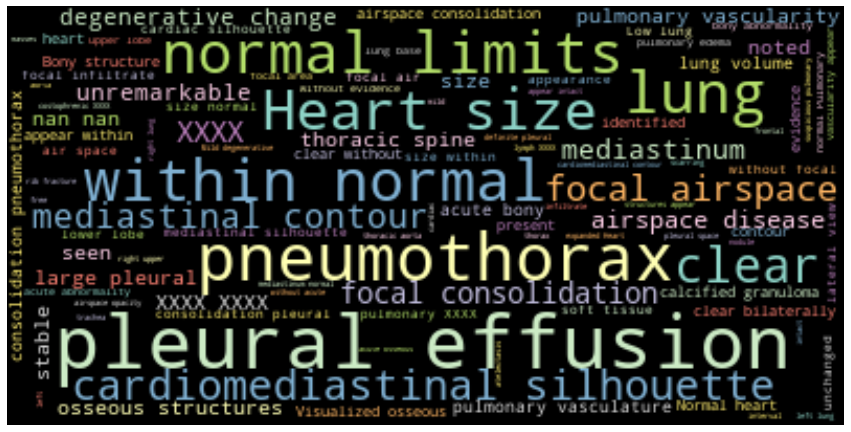

In [125]:

wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(orig_data['findings'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

no. of unique impression report in the dataset:1674
No. of impression report repeated more than one times:1474


<BarContainer object of 1 artists>

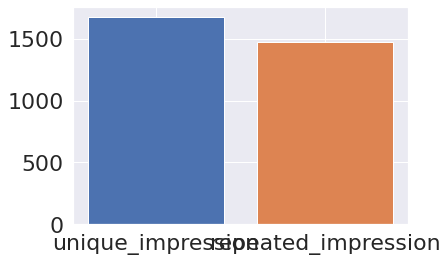

In [126]:
impression_reports=pd.Series(orig_data["impression"].tolist())
len_impression=len(impression_reports)
unique_impression_report=len(np.unique(impression_reports))
print("no. of unique impression report in the dataset:{}".format(unique_impression_report))
repeated_impression_report=np.sum(impression_reports.value_counts()>1)
print("No. of impression report repeated more than one times:{}".format(repeated_impression_report))
plt.bar(["unique_impression"], unique_impression_report)
plt.bar(["repeated_impression"], repeated_impression_report )

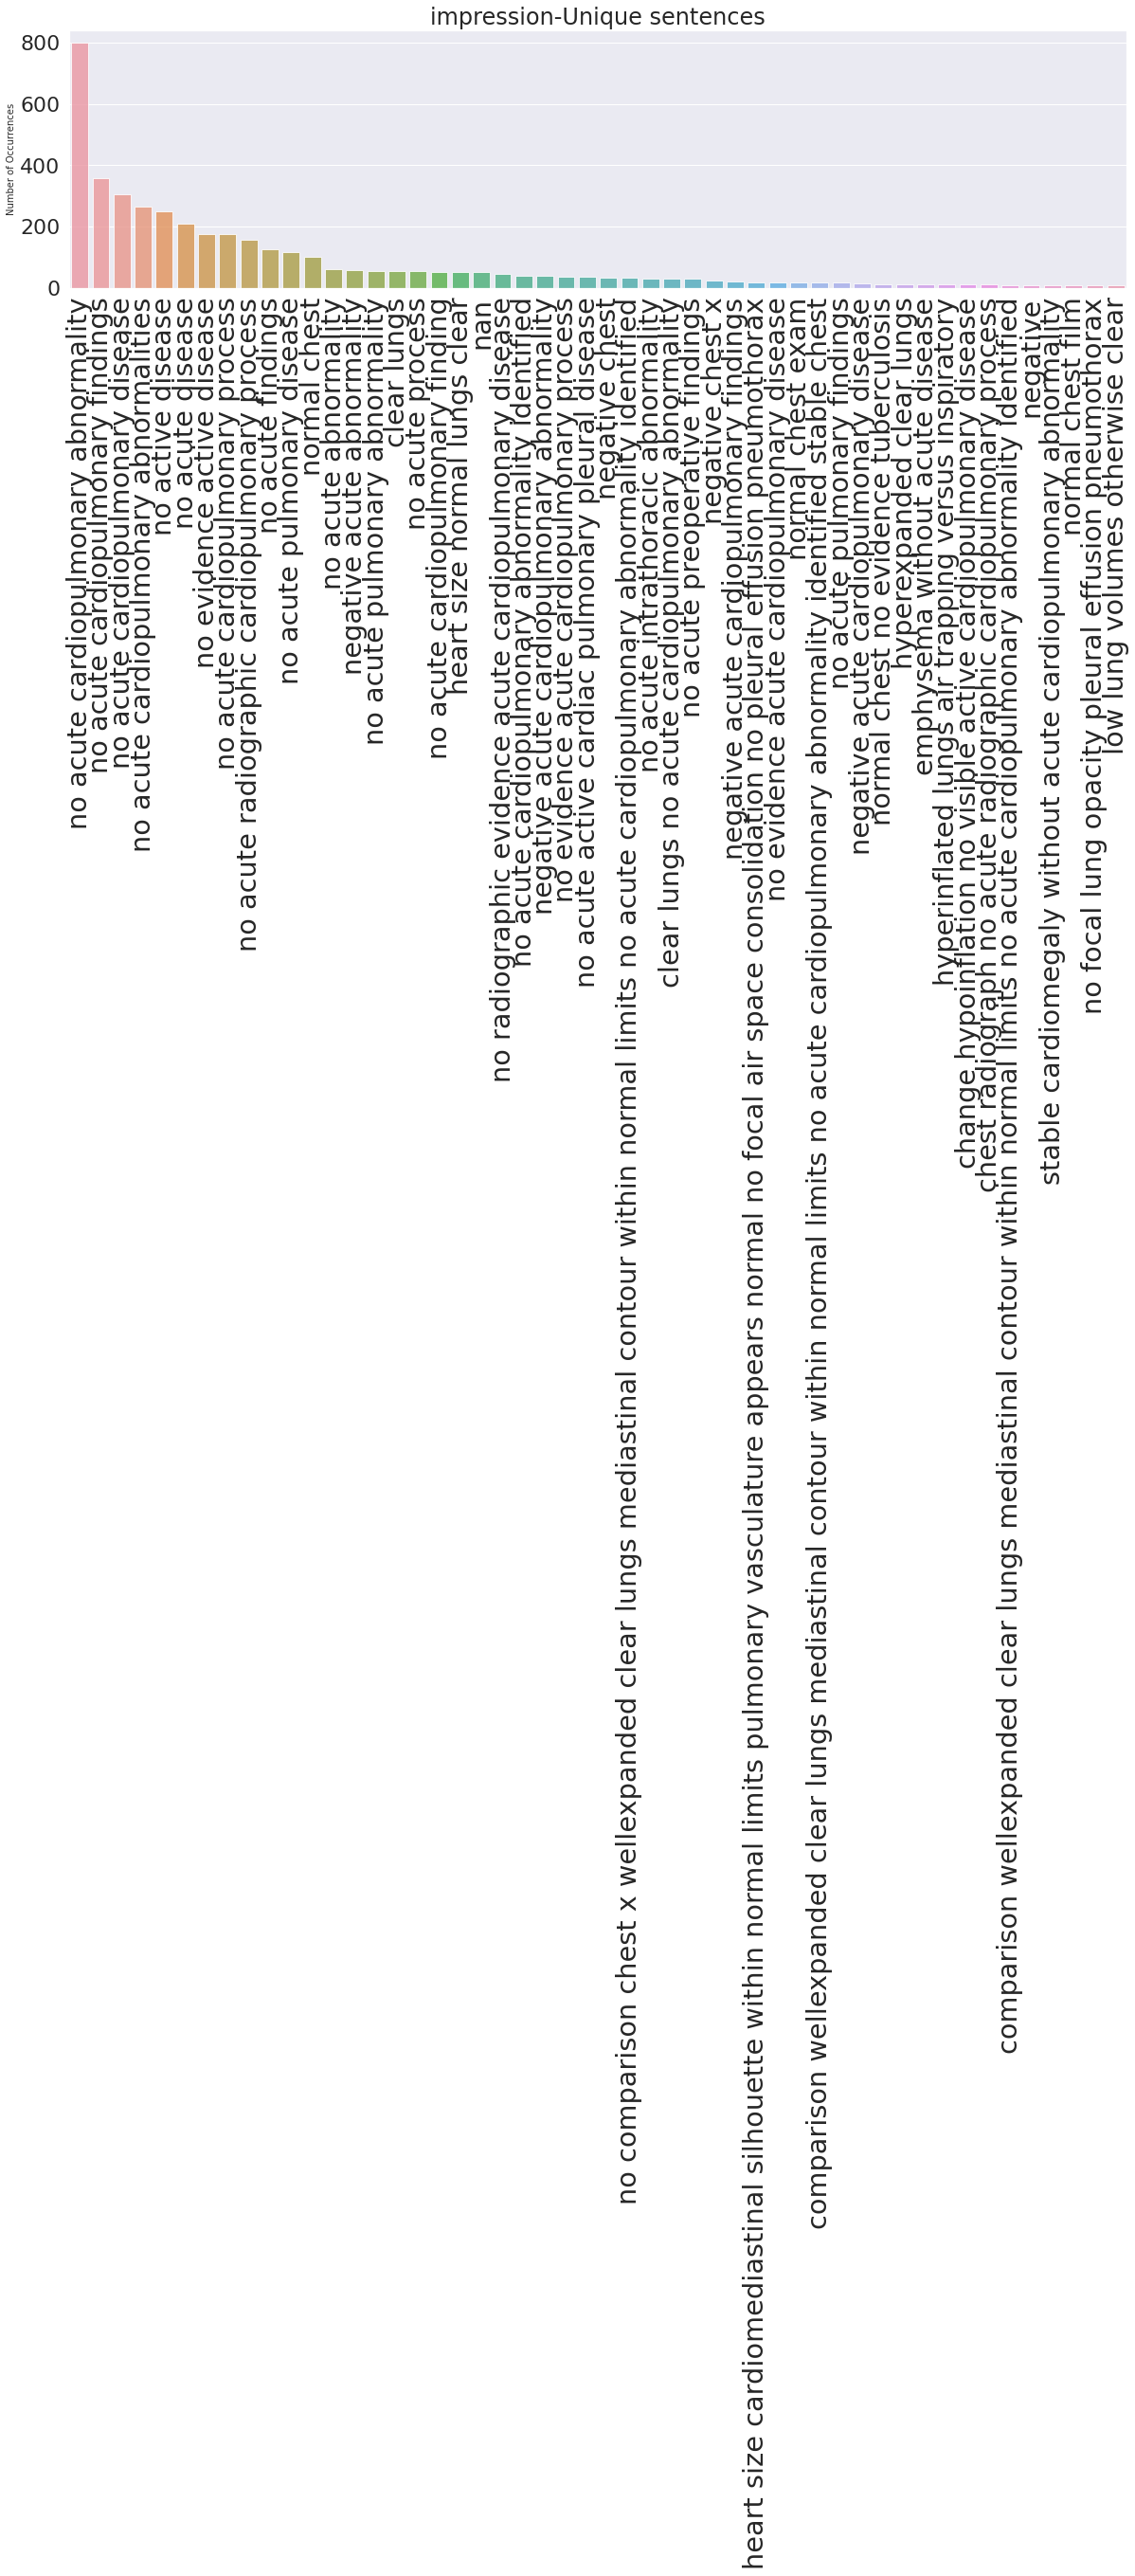

In [127]:
#Plotting top 50 frequent sentences of Indication feature
sentences = orig_data['impression'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(sentences.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("impression-Unique sentences")
plt.show()

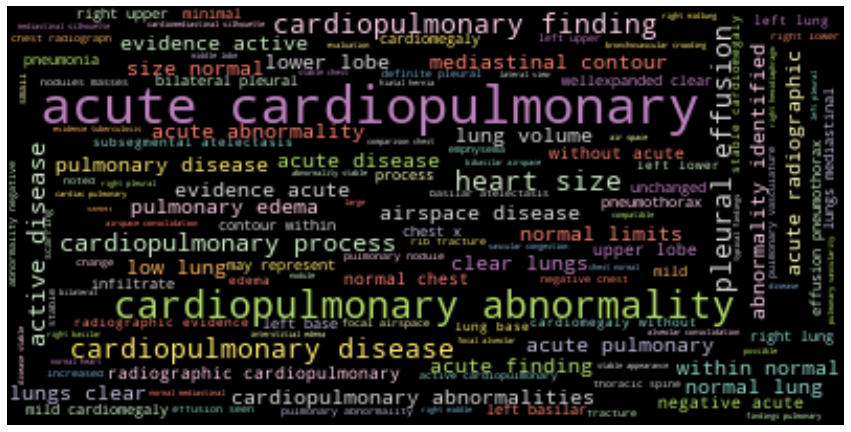

In [128]:

wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(orig_data['impression'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

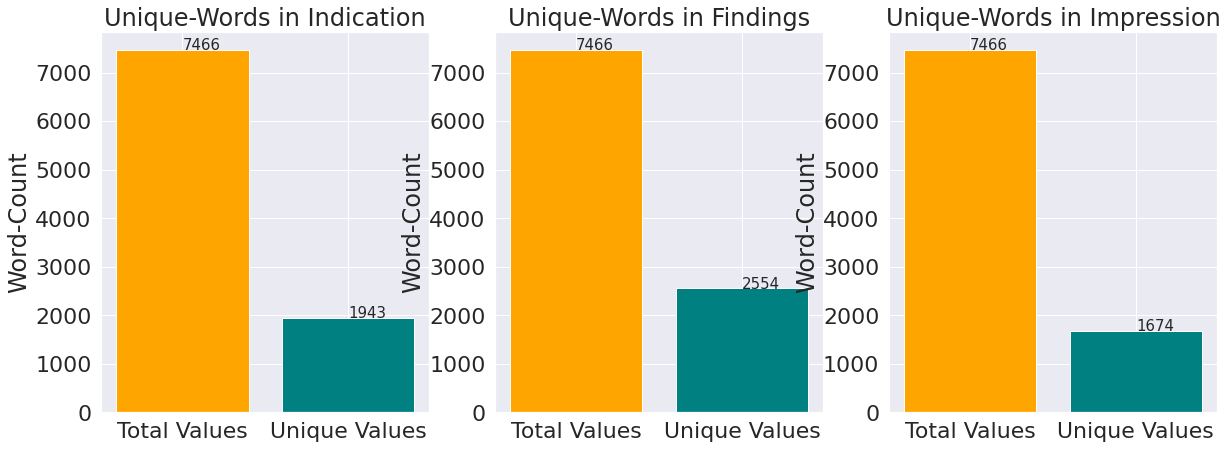

In [129]:
def unique_words_features(df):
    '''This function takes pandas dataframe and show barplot of features unique and repeated words 
       Input  =  pandas dataframe or numpy arrays
       Output =  barplot of the unique words of dataframe '''

    #length of the feature
    len_total = len(df.tolist())

    #length of unique words in the featue
    len_unique = len(np.unique(df.tolist()))

    x = ['Total Values', 'Unique Values']
    y =  [len_total, len_unique]

    plt.bar(x,y,color = ['orange','Teal'])
    plt.ylabel('Word-Count')
    for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))
    
    plt.ylabel('Word-Count')

plt.figure(figsize = (20,7))
plt.subplot(131)
unique_words_features(orig_data['indication'])
plt.title('Unique-Words in Indication')
plt.subplot(132)
unique_words_features(orig_data['findings'])
plt.title('Unique-Words in Findings')
plt.subplot(133)
unique_words_features(orig_data['impression'])
plt.title('Unique-Words in Impression')
plt.show()

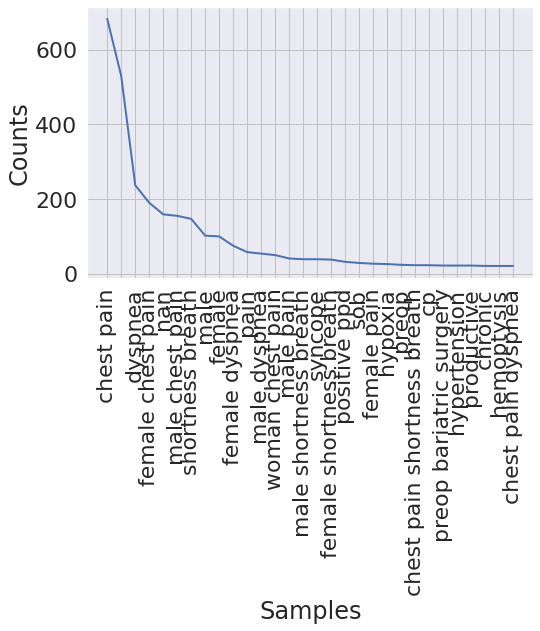

In [130]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))

sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(orig_data['indication'].tolist())
nlp_words.plot(30);
# nlp_words=nltk.FreqDist(orig_data['finding'].tolist())
# nlp_words.plot(30);


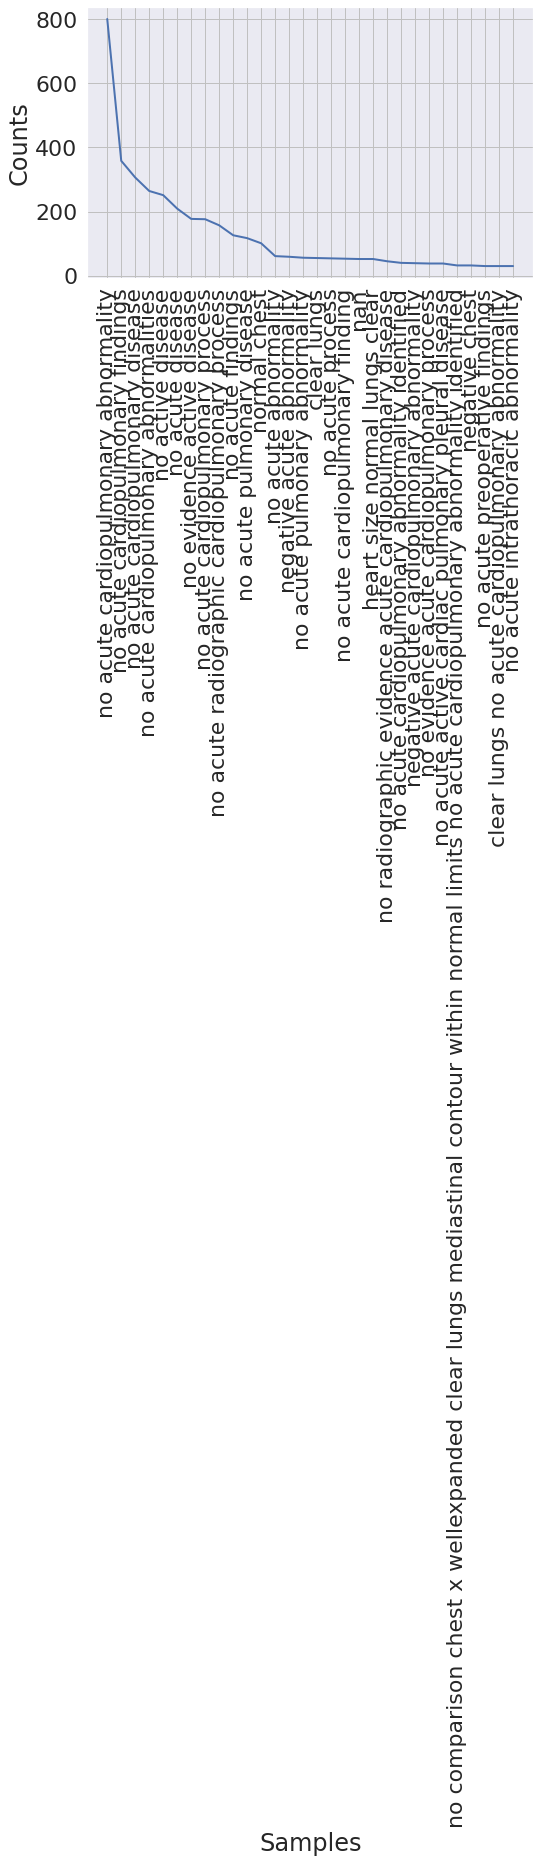

In [131]:
fig, ax = plt.subplots(figsize=(8,5))

sns.set_style('darkgrid')

nlp_words=nltk.FreqDist(orig_data['impression'].tolist())
nlp_words.plot(30);

In [132]:
from collections import Counter
def count_words(df):
  wordcount = {}
  words=[]
  for i in df:
    words.extend(i.split())

  all_stopwords = stopwords.words('english')

  for word in words:
    if word not in all_stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
  word_counter = Counter(wordcount)
  lst = word_counter.most_common(30)
  return lst
# for word, count in word_counter.most_common(30):
#     print(word, ": ", count)


In [133]:
# from itertools import count

# df = pd.DataFrame(count_words(orig_data['finding']), columns = ['Word', 'Count'])

# df.plot.bar(x='Word',y='Count', figsize=(15 ,5))
# plt.title("Top 30 words in findings")


In [134]:
# df = pd.DataFrame(count_words(orig_data['impression']), columns = ['Word', 'Count'])

# df.plot.bar(x='Word',y='Count', figsize=(15 ,5))
# plt.title("Top 30 words in impression")


In [135]:
# df = pd.DataFrame(count_words(orig_data['indication']), columns = ['Word', 'Count'])

# df.plot.bar(x='Word',y='Count', figsize=(15 ,5))
# plt.title("Top 30 words in indication")


In [136]:
orig_data.head()

uid                filename projection  \
0    1  1_IM-0001-4001.dcm.png    Frontal   
1    1  1_IM-0001-3001.dcm.png    Lateral   
2    2  2_IM-0652-1001.dcm.png    Frontal   
3    2  2_IM-0652-2001.dcm.png    Lateral   
4    3  3_IM-1384-1001.dcm.png    Frontal   

                                                MeSH  \
0                                             normal   
1                                             normal   
2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
3  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
4                                             normal   

                        Problems                                image  \
0                         normal            Xray Chest PA and Lateral   
1                         normal            Xray Chest PA and Lateral   
2  Cardiomegaly;Pulmonary Artery  Chest, 2 views, frontal and lateral   
3  Cardiomegaly;Pulmonary Artery  Chest, 2 views, frontal and lateral   
4                         normal            Xray Chest PA and Lateral   

                                          indication comparison  \
0                                   positive tb test      None.   
1                                   positive tb test      None.   
2                            preop bariatric surgery      None.   
3                            preop bariatric surgery      None.   
4  rib pain steps pain r back r elbow r rib no pr...        NaN   

                                            findings  \
0  The cardiac silhouette and mediastinum size ar...   
1  The cardiac silhouette and mediastinum size ar...   
2  Borderline cardiomegaly. Midline sternotomy XX...   
3  Borderline cardiomegaly. Midline sternotomy XX...   
4                                                NaN   

                                          impression  \
0                                     normal chest x   
1                                     normal chest x   
2                        no acute pulmonary findings   
3                        no acute pulmonary findings   
4  no displaced rib fractures pneumothorax pleura...   

                                             finding  
0  cardiac silhouette mediastinum size within nor...  
1  cardiac silhouette mediastinum size within nor...  
2  borderline cardiomegaly midline sternotomy enl...  
3  borderline cardiomegaly midline sternotomy enl...  
4                                                nan

In [137]:
model_df = orig_data[['uid', 'filename', 'findings']]
model_df

uid                   filename  \
0        1     1_IM-0001-4001.dcm.png   
1        1     1_IM-0001-3001.dcm.png   
2        2     2_IM-0652-1001.dcm.png   
3        2     2_IM-0652-2001.dcm.png   
4        3     3_IM-1384-1001.dcm.png   
...    ...                        ...   
7461  3997  3997_IM-2048-1002.dcm.png   
7462  3998  3998_IM-2048-1001.dcm.png   
7463  3998  3998_IM-2048-1002.dcm.png   
7464  3999  3999_IM-2049-1001.dcm.png   
7465  3999  3999_IM-2049-2001.dcm.png   

                                               findings  
0     The cardiac silhouette and mediastinum size ar...  
1     The cardiac silhouette and mediastinum size ar...  
2     Borderline cardiomegaly. Midline sternotomy XX...  
3     Borderline cardiomegaly. Midline sternotomy XX...  
4                                                   NaN  
...                                                 ...  
7461  Heart size within normal limits. Small, nodula...  
7462                                                NaN  
7463                                                NaN  
7464                                                NaN  
7465                                                NaN  

[7466 rows x 3 columns]

In [138]:
temp_df = model_df[(model_df.index )%2!=0]
temp_df.rename(columns={'filename':'filename1'}, inplace=True)
temp_df

uid                  filename1  \
1        1     1_IM-0001-3001.dcm.png   
3        2     2_IM-0652-2001.dcm.png   
5        3     3_IM-1384-2001.dcm.png   
7        4     4_IM-2050-2001.dcm.png   
9        5  5_IM-2117-1004003.dcm.png   
...    ...                        ...   
7457  3995  3995_IM-2046-2001.dcm.png   
7459  3996  3996_IM-2047-3001.dcm.png   
7461  3997  3997_IM-2048-1002.dcm.png   
7463  3998  3998_IM-2048-1002.dcm.png   
7465  3999  3999_IM-2049-2001.dcm.png   

                                               findings  
1     The cardiac silhouette and mediastinum size ar...  
3     Borderline cardiomegaly. Midline sternotomy XX...  
5                                                   NaN  
7     There are diffuse bilateral interstitial and a...  
9     The cardiomediastinal silhouette and pulmonary...  
...                                                 ...  
7457  The cardiomediastinal silhouette and pulmonary...  
7459  The lungs are clear. Heart size is normal. No ...  
7461  Heart size within normal limits. Small, nodula...  
7463                                                NaN  
7465                                                NaN  

[3733 rows x 3 columns]

In [139]:
model_df = model_df[(model_df.index )%2==0].copy()
model_df.rename(columns={'filename':'filename2'}, inplace=True)
temp_df2 = model_df.copy()

In [140]:
temp_df2

uid                  filename2  \
0        1     1_IM-0001-4001.dcm.png   
2        2     2_IM-0652-1001.dcm.png   
4        3     3_IM-1384-1001.dcm.png   
6        4     4_IM-2050-1001.dcm.png   
8        5  5_IM-2117-1003002.dcm.png   
...    ...                        ...   
7456  3995  3995_IM-2046-1001.dcm.png   
7458  3996  3996_IM-2047-1001.dcm.png   
7460  3997  3997_IM-2048-1001.dcm.png   
7462  3998  3998_IM-2048-1001.dcm.png   
7464  3999  3999_IM-2049-1001.dcm.png   

                                               findings  
0     The cardiac silhouette and mediastinum size ar...  
2     Borderline cardiomegaly. Midline sternotomy XX...  
4                                                   NaN  
6     There are diffuse bilateral interstitial and a...  
8     The cardiomediastinal silhouette and pulmonary...  
...                                                 ...  
7456  The cardiomediastinal silhouette and pulmonary...  
7458  The lungs are clear. Heart size is normal. No ...  
7460  Heart size within normal limits. Small, nodula...  
7462                                                NaN  
7464                                                NaN  

[3733 rows x 3 columns]

In [141]:
model_df  = pd.merge(temp_df, temp_df2, on="uid")
model_df.drop(columns={'findings_y'}, inplace=True)
model_df.rename(columns={'findings_x':'findings'}, inplace=True)
model_df=model_df[['uid', 'filename1', 'filename2','findings']]
model_df

uid                  filename1                  filename2  \
0        1     1_IM-0001-3001.dcm.png     1_IM-0001-4001.dcm.png   
1        2     2_IM-0652-2001.dcm.png     2_IM-0652-1001.dcm.png   
2        3     3_IM-1384-2001.dcm.png     3_IM-1384-1001.dcm.png   
3        4     4_IM-2050-2001.dcm.png     4_IM-2050-1001.dcm.png   
4        5  5_IM-2117-1004003.dcm.png  5_IM-2117-1003002.dcm.png   
...    ...                        ...                        ...   
3625  3995  3995_IM-2046-2001.dcm.png  3995_IM-2046-1001.dcm.png   
3626  3996  3996_IM-2047-3001.dcm.png  3996_IM-2047-1001.dcm.png   
3627  3997  3997_IM-2048-1002.dcm.png  3997_IM-2048-1001.dcm.png   
3628  3998  3998_IM-2048-1002.dcm.png  3998_IM-2048-1001.dcm.png   
3629  3999  3999_IM-2049-2001.dcm.png  3999_IM-2049-1001.dcm.png   

                                               findings  
0     The cardiac silhouette and mediastinum size ar...  
1     Borderline cardiomegaly. Midline sternotomy XX...  
2                                                   NaN  
3     There are diffuse bilateral interstitial and a...  
4     The cardiomediastinal silhouette and pulmonary...  
...                                                 ...  
3625  The cardiomediastinal silhouette and pulmonary...  
3626  The lungs are clear. Heart size is normal. No ...  
3627  Heart size within normal limits. Small, nodula...  
3628                                                NaN  
3629                                                NaN  

[3630 rows x 4 columns]

In [142]:
model_df[model_df['findings'].isnull()]

uid                     filename1                     filename2  \
2        3        3_IM-1384-2001.dcm.png        3_IM-1384-1001.dcm.png   
15      16       16_IM-0389-2001.dcm.png       16_IM-0389-1001.dcm.png   
20      21  21_IM-0729-1001-0002.dcm.png  21_IM-0729-1001-0001.dcm.png   
28      29       29_IM-1302-2001.dcm.png       29_IM-1302-1001.dcm.png   
30      31       31_IM-1450-3003.dcm.png       31_IM-1450-1001.dcm.png   
...    ...                           ...                           ...   
3597  3968     3968_IM-2029-3001.dcm.png     3968_IM-2029-1001.dcm.png   
3598  3968     3968_IM-2029-3001.dcm.png     3968_IM-2029-2001.dcm.png   
3622  3992     3992_IM-2044-2001.dcm.png     3992_IM-2044-1001.dcm.png   
3628  3998     3998_IM-2048-1002.dcm.png     3998_IM-2048-1001.dcm.png   
3629  3999     3999_IM-2049-2001.dcm.png     3999_IM-2049-1001.dcm.png   

     findings  
2         NaN  
15        NaN  
20        NaN  
28        NaN  
30        NaN  
...       ...  
3597      NaN  
3598      NaN  
3622      NaN  
3628      NaN  
3629      NaN  

[484 rows x 4 columns]

In [143]:
model_df = model_df[model_df.findings.notnull()]
print(model_df.shape)
# uni_filenames1 = (model_df.images_id1.values)
# uni_filenames2= model_df.images_id2.values


model_df.head()


(3146, 4)


uid                  filename1                  filename2  \
0    1     1_IM-0001-3001.dcm.png     1_IM-0001-4001.dcm.png   
1    2     2_IM-0652-2001.dcm.png     2_IM-0652-1001.dcm.png   
3    4     4_IM-2050-2001.dcm.png     4_IM-2050-1001.dcm.png   
4    5  5_IM-2117-1004003.dcm.png  5_IM-2117-1003002.dcm.png   
5    6     6_IM-2192-2001.dcm.png     6_IM-2192-1001.dcm.png   

                                            findings  
0  The cardiac silhouette and mediastinum size ar...  
1  Borderline cardiomegaly. Midline sternotomy XX...  
3  There are diffuse bilateral interstitial and a...  
4  The cardiomediastinal silhouette and pulmonary...  
5  Heart size and mediastinal contour are within ...

In [144]:
uni_filenames1 = (model_df.filename1.values)
uni_filenames2= model_df.filename2.values

In [145]:
uni_filenames1

array(['1_IM-0001-3001.dcm.png', '2_IM-0652-2001.dcm.png',
       '4_IM-2050-2001.dcm.png', ..., '3995_IM-2046-2001.dcm.png',
       '3996_IM-2047-3001.dcm.png', '3997_IM-2048-1002.dcm.png'],
      dtype=object)

In [146]:
uni_filenames2

array(['1_IM-0001-4001.dcm.png', '2_IM-0652-1001.dcm.png',
       '4_IM-2050-1001.dcm.png', ..., '3995_IM-2046-1001.dcm.png',
       '3996_IM-2047-1001.dcm.png', '3997_IM-2048-1001.dcm.png'],
      dtype=object)

In [147]:
# !unzip -q "/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/TransChex_openi/images.zip"

#### Next, let’s visualize a few images and their 5 captions

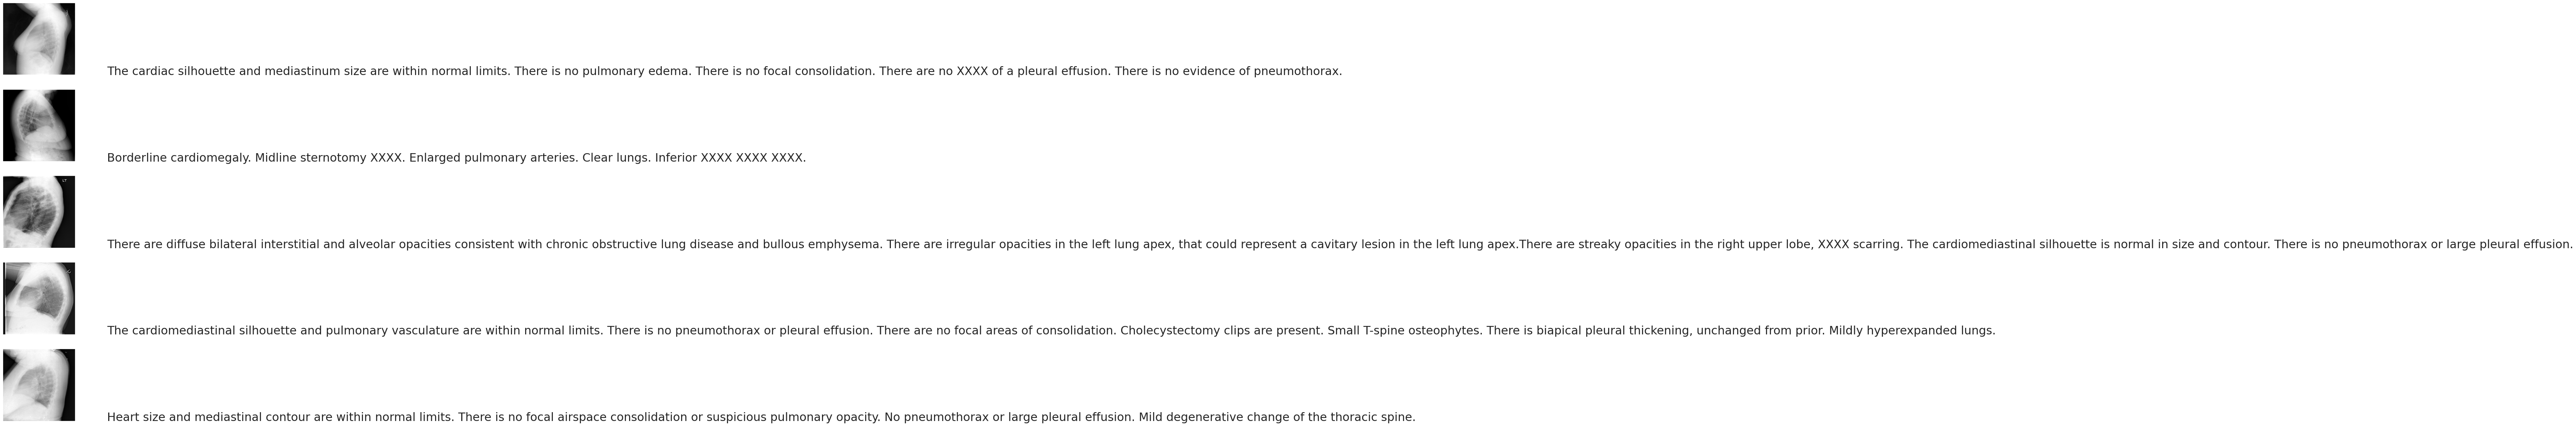

In [148]:
from tensorflow.keras.utils import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1
image_path = '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/images.zip (Unzipped Files)/images/images_normalized'

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames1[0:5]:
   filename = image_path + '/' + jpgfnm
   captions = list(model_df["findings"].loc[model_df["filename1"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=30)
   count += 1
plt.show()

In [149]:
vocabulary = []
for txt in model_df.findings.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 2626


#### Next perform some text cleaning such as removing punctuation, single characters, and numeric values:

In [150]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(model_df.findings.values):
   newcaption = text_clean(caption)
   model_df["findings"].iloc[i] = newcaption

In [151]:
clean_vocabulary = []
for txt in model_df.findings.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 1640


#### Next, we save all the captions and image paths in two lists so that we can load the images at once using the path set. We also add ‘< start >’ and ‘< end >’ tags to every caption so that the model understands the starting and end of each caption.

In [152]:
PATH = "/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/images.zip (Unzipped Files)/images/images_normalized/"
all_captions = []
for caption  in model_df.findings.astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  The cardiac silhouette and mediastinum size are within normal There is no pulmonary There is no focal There are no XXXX of pleural There is no evidence of <end>',
 '<start>  Borderline Midline sternotomy Enlarged pulmonary Clear Inferior XXXX XXXX <end>',
 '<start>  There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous There are irregular opacities in the left lung that could represent cavitary lesion in the left lung are streaky opacities in the right upper XXXX The cardiomediastinal silhouette is normal in size and There is no pneumothorax or large pleural <end>',
 '<start>  The cardiomediastinal silhouette and pulmonary vasculature are within normal There is no pneumothorax or pleural There are no focal areas of Cholecystectomy clips are Small There is biapical pleural unchanged from Mildly hyperexpanded <end>',
 '<start>  Heart size and mediastinal contour are within normal There is no focal airspace 

In [153]:
all_img_name_vector = []
for annot in model_df["filename1"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/images.zip (Unzipped Files)/images/images_normalized/1_IM-0001-3001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/images.zip (Unzipped Files)/images/images_normalized/2_IM-0652-2001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/images.zip (Unzipped Files)/images/images_normalized/4_IM-2050-2001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/images.zip (Unzipped Files)/images/images_normalized/5_IM-2117-1004003.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/images.zip (Unzipped Files)/images/images_normalized/6_IM-2192-2001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/images.zip (Unzipped Files)/images/images_normalized/7_IM-2263-2001.dcm.png',
 '/content/gdrive/MyDrive/Data606_Capstone_project_folder/data/images.zip (Unzipped Files)/images/images_normalized/8_IM-2333-2001.dcm.png',
 '/content

In [154]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 3146
len(all_captions) : 3146


In [155]:
def data_limiter(num,total_captions,all_img_name_vector):
   train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
   train_captions = train_captions[:num]
   img_name_vector = img_name_vector[:num]
   return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(3136,all_captions,all_img_name_vector)   #3136 = 16*196

### Model Definition
#### Let’s define the image feature extraction model using InceptionV3. We only need to extract an image vector for our images. We must all preprocess all the images to the same size, i.e, 299×299 before feeding them into the model, and the shape of the output of this layer is 8x8x2048.

In [156]:

def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (299, 299))
   img = tf.keras.applications.inception_v3.preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

#### Next, let’s Map each image name to the function to load the image. We will pre-process each image with InceptionV3 and cache the output to disk and image features are reshaped to 64×2048.

In [157]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16) #batch size 16

In [158]:
image_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

We extract the features and store them in the respective .npy files and then pass those features through the encoder.NPY files store all the information required to reconstruct an array on any computer, which includes dtype and shape information.

In [159]:
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                            (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 191/191 [17:14<00:00,  5.41s/it]


#### Next, we tokenize the captions and build a vocabulary of all the unique words in the data. We will also limit the vocabulary size to the top 5000 words to save memory. We will replace words not in vocabulary with the token 

In [160]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

#### Next, Create training and validation sets using an 80-20 split:



In [161]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)


#### Next, let’s create a tf.data dataset to use for training our model.

In [162]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
   return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Step 4:- Positional Encoding 
#### The positional encoding uses sine and cosine functions of different frequencies. For every odd index on the input vector, create a vector using the cos function, for every even index, create a vector using the sin function. Then add those vectors to their corresponding input embeddings which successfully gives the network information on the position of each vector.

In [163]:
def get_angles(pos, i, d_model):
   angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
   return pos * angle_rates

def positional_encoding_1d(position, d_model):
   angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

   angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
   angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
   pos_encoding = angle_rads[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
   assert d_model % 2 == 0
   row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
   col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
   angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
   angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

   angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
   angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
   angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
   angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
   pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)


### Step 5:- Multi-Head Attention
#### Calculate the attention weights. q, k, v must have matching leading dimensions. k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v. The mask has different shapes depending on its type (padding or look ahead) but it must be broadcastable for addition.

In [164]:
def create_padding_mask(seq):
   seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
   return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
   return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
   matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
   dk = tf.cast(tf.shape(k)[-1], tf.float32)
   scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

   if mask is not None:
      scaled_attention_logits += (mask * -1e9) 

   attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
   output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

   return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads):
      super(MultiHeadAttention, self).__init__()
      self.num_heads = num_heads
      self.d_model = d_model
      assert d_model % self.num_heads == 0
      self.depth = d_model // self.num_heads
      self.wq = tf.keras.layers.Dense(d_model)
      self.wk = tf.keras.layers.Dense(d_model)
      self.wv = tf.keras.layers.Dense(d_model)
      self.dense = tf.keras.layers.Dense(d_model)

   def split_heads(self, x, batch_size):
      x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(x, perm=[0, 2, 1, 3])

   def call(self, v, k, q, mask=None):
      batch_size = tf.shape(q)[0]
      q = self.wq(q)  # (batch_size, seq_len, d_model)
      k = self.wk(k)  # (batch_size, seq_len, d_model)
      v = self.wv(v)  # (batch_size, seq_len, d_model)

      q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
      k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
      v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

      scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

      concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

      output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
      return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
   return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
                ])



### Step 6:- Encoder-Decoder Layer

In [165]:
class EncoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(EncoderLayer, self).__init__()
      self.mha = MultiHeadAttention(d_model, num_heads)
      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)


   def call(self, x, training, mask=None):
      attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

      ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
      ffn_output = self.dropout2(ffn_output, training=training)
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
      return out2

In [166]:
class DecoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(DecoderLayer, self).__init__()
      self.mha1 = MultiHeadAttention(d_model, num_heads)
      self.mha2 = MultiHeadAttention(d_model, num_heads)

      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dropout3 = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
      attn1 = self.dropout1(attn1, training=training)
      out1 = self.layernorm1(attn1 + x)

      attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
      attn2 = self.dropout2(attn2, training=training)
      out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
      ffn_output = self.dropout3(ffn_output, training=training)
      out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

      return out3, attn_weights_block1, attn_weights_block2

In [167]:
class Encoder(tf.keras.layers.Layer):
   def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.1):
      super(Encoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
      self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

      self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, training, mask=None):
      seq_len = tf.shape(x)[1]
      x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x = self.enc_layers[i](x, training, mask)

      return x  # (batch_size, input_seq_len, d_model)

In [168]:
class Decoder(tf.keras.layers.Layer):
   def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
      self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

      self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      seq_len = tf.shape(x)[1]
      attention_weights = {}

      x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
         attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
         attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

      return x, attention_weights

### Step 7:- Transformer 

In [169]:
class Transformer(tf.keras.Model):
   def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
      super(Transformer, self).__init__()
      self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
      self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                          target_vocab_size,max_pos_encoding, rate)
      self.final_layer = tf.keras.layers.Dense(target_vocab_size)

   def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
      enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
      dec_output, attention_weights = self.decoder(
      tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
      return final_output, attention_weights

### Step 8:- Model Hyperparameters
### Define the parameters for training:

In [170]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1

In [171]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, d_model, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)
      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [172]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
   mask = tf.math.logical_not(tf.math.equal(real, 0))
   loss_ = loss_object(real, pred)
   mask = tf.cast(mask, dtype=loss_.dtype)
   loss_ *= mask
   return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [173]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

### Step 9:- Model Training

In [174]:
def create_masks_decoder(tar):
   look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
   dec_target_padding_mask = create_padding_mask(tar)
   combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
   return combined_mask

In [175]:
@tf.function
def train_step(img_tensor, tar):
   tar_inp = tar[:, :-1]
   tar_real = tar[:, 1:]
   dec_mask = create_masks_decoder(tar_inp)
   with tf.GradientTape() as tape:
      predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
      loss = loss_function(tar_real, predictions)

   gradients = tape.gradient(loss, transformer.trainable_variables)   
   optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
   train_loss(loss)
   train_accuracy(tar_real, predictions)

In [176]:
for epoch in range(7):
   start = time.time()
   train_loss.reset_states()
   train_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(dataset):
      train_step(img_tensor, tar)
      if batch % 50 == 0:
         print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))

   print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
   print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.6555 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.1444 Accuracy 0.0052
Epoch 1 Batch 100 Loss 7.6127 Accuracy 0.0096
Epoch 1 Batch 150 Loss 7.2221 Accuracy 0.0108
Epoch 1 Loss 7.1771 Accuracy 0.0110
Time taken for 1 epoch: 1218.138531446457 secs

Epoch 2 Batch 0 Loss 6.3084 Accuracy 0.0176
Epoch 2 Batch 50 Loss 5.5609 Accuracy 0.0218
Epoch 2 Batch 100 Loss 5.0893 Accuracy 0.0337
Epoch 2 Batch 150 Loss 4.7127 Accuracy 0.0421
Epoch 2 Loss 4.6777 Accuracy 0.0429
Time taken for 1 epoch: 1217.9147906303406 secs

Epoch 3 Batch 0 Loss 4.0511 Accuracy 0.0556
Epoch 3 Batch 50 Loss 3.5648 Accuracy 0.0690
Epoch 3 Batch 100 Loss 3.4323 Accuracy 0.0730
Epoch 3 Batch 150 Loss 3.2935 Accuracy 0.0758
Epoch 3 Loss 3.2744 Accuracy 0.0761
Time taken for 1 epoch: 1222.2976348400116 secs

Epoch 4 Batch 0 Loss 3.1484 Accuracy 0.0954
Epoch 4 Batch 50 Loss 2.8728 Accuracy 0.0866
Epoch 4 Batch 100 Loss 2.7861 Accuracy 0.0885
Epoch 4 Batch 150 Loss 2.7229 Accuracy 0.0907
Epoch 4 Loss 2.7136 Ac

In [177]:
def evaluate(image):
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = tokenizer.word_index['<start>']
   end_token = tokenizer.word_index['<end>']
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   for i in range(100):
      dec_mask = create_masks_decoder(output)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0), attention_weights
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

   return result,tf.squeeze(output, axis=0), attention_weights

BLEU-1 score: 22.73871594750492
BLEU-2 score: 6.494920916966264e-153
BLEU-3 score: 1.4459810340213669e-183
BLEU-4 score: 1.0976852611324292e-229
Real Caption: no focal no visualized heart size is cardiac and mediastinal silhouette is grossly
Predicted Caption: the heart is normal in the mediastinum is the lungs are


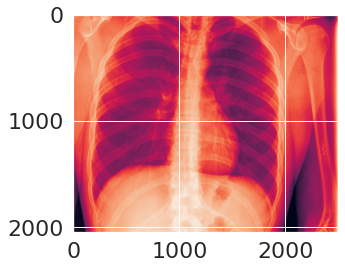

In [178]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_caption:
   if i=="<unk>":
      real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 13.377434224416085
BLEU-2 score: 3.3091113932923515e-153
BLEU-3 score: 6.955243976325295e-184
BLEU-4 score: 5.204519837132902e-230
Real Caption: midline sternotomy xxxx heart size and cardiomediastinal silhouette are grossly airspace opacity in posterior segment on the lateral osseous structures are grossly
Predicted Caption: the heart is normal in the mediastinum is the lungs are


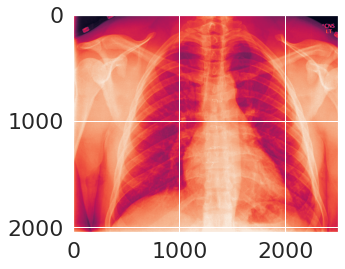

In [179]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_caption:
   if i=="<unk>":
      real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)